In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re

In [66]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
            except:
                pass
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [67]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [68]:
experiment_logs = './results/booking_config_2021_01_12T21_05_12/stdout'
data = get_data_from_logs(experiment_logs, 0)


In [69]:
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
top_recommender,0.015766,0.063063,0.039516,0.085549,0.122494,0.010478,{},[]
conditional_top_recommender,0.094094,0.372372,0.289590,0.361719,0.008951,0.017133,{},[]
transitions_chain_recommender,0.109860,0.439439,0.343552,0.432880,1.920057,13.885552,{},[]
APREC-GMLPHE-Lambdarank-128,0.127127,0.508509,0.411769,0.491176,23902.767191,31.278499,"{'epochs_trained': 33, 'best_val_ndcg': 0.4816...","[{'loss': 5.4725, 'ndcg_at_40': 0.1796, 'Succe..."
APREC-GMLPHE-Lambdarank-256,0.127377,0.509510,0.410000,0.493750,32996.519187,31.070139,"{'epochs_trained': 55, 'best_val_ndcg': 0.5014...","[{'loss': 5.5887, 'ndcg_at_40': 0.1841, 'Succe..."


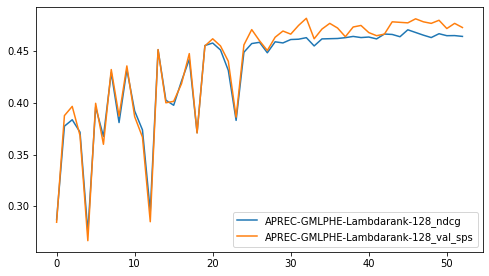

In [78]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(8, 4.5))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = get_metric(history, 'val_ndcg_at_40')
        
        success = get_metric(history, 'Success_at_4')
        val_success = get_metric(history, 'val_Success_at_4')
        
        plt.plot(val_ndcg, label=recommender['model_name'] + "_ndcg")
        plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
        break
plt.legend()


In [7]:
max(recommender['model_metadata']['val_success_history'])

0.4608449935913086

In [8]:
arr= recommender['model_metadata']['val_success_history']

In [10]:
best = 0
time_since_best = []
for i in range (1, len(arr)):
    if arr[i] > arr[best]:
        best = i
    time_since_best.append(i - best)

In [12]:
plt.plot(time_since_best)